In [68]:
import os
import struct
import pickle
import shutil
from typing import List

import numpy as np
# Okay, this is for using GPU POWEEEER
import cupy as cp
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(cp.cuda.runtime.getDeviceCount())

1


# Reading Data

In [69]:
def load_images(path: str):
    # Images in 784x1 format
    images = []
    
    with open(path, mode='rb') as f:
        # Read header values
        magic_number, n, rows, cols = struct.unpack('>IIII', f.read(16))
        
        for _ in range(n):
            # Read and unpack image (which has 28x28 bytes)
            image = list(struct.unpack('>' + 'B' * (rows * cols), f.read(rows * cols)))
            images.append(image)
    
    return np.array(images)

In [70]:
def load_labels(path: str):
    with open(path, mode='rb') as f:
        # Read header values
        magic_number, n = struct.unpack('>II', f.read(8))
        
        # Read and return labels
        return np.array(struct.unpack('>' + 'B' * n, f.read(n)))

In [71]:
def save_file(path, data):
    with open(path, 'wb') as f:
        f.write(data)

In [72]:
train_images_path = "train-images.idx3-ubyte"
train_labels_path = "train-labels.idx1-ubyte"
test_images_path = "t10k-images.idx3-ubyte"
test_labels_path = "t10k-labels.idx1-ubyte"

train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

## Whitening (Z-Scoring) data

In [73]:
def z_score(data):
    mean = np.mean(data)
    std = np.std(data)
    return mean, std, (data - mean) / std

In [74]:
mean, std, train_images = z_score(train_images)

In [75]:
test_images = (test_images - mean) / std

In [76]:
save_file("preprocessed_data/train_images", train_images)
save_file("preprocessed_data/test_images", test_images)

# Re-shape and Visualization

In [77]:
def reshape_matrix_to_images(matrix_images):
    apply_function = lambda row: row.reshape((28, 28))
    return np.apply_along_axis(apply_function, axis=1, arr=matrix_images)

In [78]:
def plot_image(reshaped_image, label = ""):
    plt.imshow(reshaped_image, cmap=plt.get_cmap('gray'))
    if label != "":
        plt.title(f"Label: {label}")
    plt.show()

## Checking image-label pair

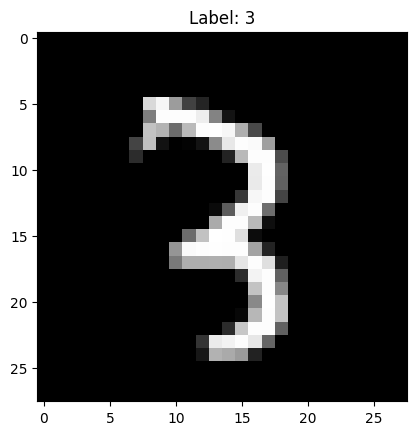

In [79]:
reshaped_images = reshape_matrix_to_images(train_images)
rand_index = np.random.randint(0, len(train_images))
plot_image(reshaped_images[rand_index], train_labels[rand_index])

In [80]:
def one_hot_encoding(labels):
    one_hot_encoded_labels = []
    for i, label in enumerate(labels):
        one_hot_label = np.zeros(10)
        one_hot_label[label] = 1.0
        one_hot_encoded_labels.append(one_hot_label)
    
    return np.array(one_hot_encoded_labels)

In [81]:
def one_hot_decoding(one_hot_encoded_labels):
    if len(one_hot_encoded_labels.shape) == 1:
        return np.argmax(one_hot_encoded_labels)
    return np.argmax(one_hot_encoded_labels, axis=1)

In [82]:
train_encoded_labels = one_hot_encoding(train_labels)
test_encoded_labels = one_hot_encoding(test_labels)

## Checking 'one_hot_encoding' and 'one_hot_decoding' functions working correct

In [83]:
train_encoded_labels[8:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [84]:
train_labels[8:10]

array([1, 4])

In [85]:
one_hot_decoding(train_encoded_labels[8:10])

array([1, 4])

# NN

## Activation Functions

In [19]:
from abc import ABC, abstractmethod


class ActivationFunction(ABC):
    def __init__(self, cuda=False):
        self.cuda = cuda
    
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def derivatives(self, x):
        pass

class Relu(ActivationFunction):
    def forward(self, x):
        if self.cuda:
            return cp.maximum(0, x)
        
        return np.maximum(x, 0)
    
    def derivatives(self, x):
        if self.cuda:
            x = cp.asarray(x)
        
        return x > 0

class Softmax(ActivationFunction):
    def forward(self, x):
        if self.cuda:
            x = cp.asarray(x)
            exps = cp.exp(x - cp.max(x))
            return exps / cp.sum(exps)
            
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps)
    
    def derivatives(self, x):
        # This is not implemented because we use cross-categorical loss and we skip this step
        return 1

## Weight Initializers

In [20]:
class WeightInitializer(ABC):
    @abstractmethod
    def init(self, n_in, n_out, cuda=False):
        pass
    
class NormalInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        if cuda:
            return cp.random.standard_normal(size=(n_in, n_out))
        
        return np.random.standard_normal(size=(n_in, n_out))
    
class XavierInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        if cuda:
            return cp.random.normal(0, 1/n_in, size=(n_in, n_out))
        
        return np.random.normal(0, 1/n_in, size=(n_in, n_out))

# Weights initializer from given research paper and yes, it works SUPER
class PaperInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        if cuda:
            return cp.random.normal(0, np.sqrt(2/n_in), size=(n_in, n_out))
        
        return np.random.normal(0, np.sqrt(2/n_in), size=(n_in, n_out))
    
class ZeroInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        if cuda:
            return cp.zeros((n_in, n_out))
        return np.zeros((n_in, n_out))
    
class VeryLargeInitializer(WeightInitializer):
    def init(self, n_in, n_out, cuda=False):
        if cuda:
            return cp.random.normal(1000, 500, size=(n_in, n_out))
        return np.random.normal(1000, 500, size=(n_in, n_out))

## Optimizers

In [21]:
class Optimizer(ABC):
    def __init__(self, cuda=False):
        self.weights = None
        self.bias = None
        self.cuda = cuda
    
    def set_weights_and_bias(self, weights, bias):
        self.weights = weights
        self.bias = bias
        
    def convert_to_cupy_array(self, dW, db):
        return cp.asarray(dW), cp.asarray(db)
    
    @abstractmethod
    def optimize(self, hyperparams, dW, db):
        pass

class SGD(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
    
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        self.weights -= lr * dW
        self.bias -= lr * db

class Momentum(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
        self.v = 0
    
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        beta = hyperparams["beta1"]
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        self.v = beta * self.v + (1 - beta) * dW
        
        self.weights -= lr * self.v
        self.bias -= lr * db
        
class RMSProp(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
        self.s = 0
    
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        beta2 = hyperparams['beta2']
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        dW = dW ** 2
        
        self.s = beta2 * self.s + (1 - beta2) * dW
        
        self.weights -= lr * dW / np.sqrt(self.s + 1e-10)
        self.bias -= lr * db
        
class Adam(Optimizer):
    def __init__(self, cuda=False):
        super().__init__(cuda)
        self.v = 0
        self.s = 0
        
    def optimize(self, hyperparams, dW, db):
        lr = hyperparams['learning_rate']
        beta1 = hyperparams['beta1']
        beta2 = hyperparams['beta2']
        epochs = hyperparams['epochs']
        
        if self.cuda:
            dW, db = self.convert_to_cupy_array(dW, db)
        
        self.v = beta1 * self.v + (1 - beta1) * dW
        self.s = beta2 * self.s + (1 - beta2) * dW**2
        
        self.weights -= lr * self.v / np.sqrt(self.s + 1e-10)
        self.bias -= lr * db
        
        self.v = self.v / (1.0 - np.pow(beta1, epochs))
        self.s = self.s / (1.0 - np.pow(beta2, epochs))

## Loss Functions

In [22]:
class LossFunction(ABC):
    def __init__(self, cuda=False):
        self.cuda = cuda
    
    @abstractmethod
    def loss(self, y_pred, y_true):
        pass
    
    @abstractmethod
    def gradient(self, y_pred, y_true):
        pass

class MSE(LossFunction):
    def __init__(self, cuda=False):
        super().__init__(cuda)
    
    def loss(self, y_pred, y_true):
        if self.cuda:
            return cp.mean((y_pred - y_true) ** 2)
        
        return np.mean((y_pred - y_true) ** 2)
    
    def gradient(self, y_pred, y_true):
        return (y_pred - y_true) * 2
    
class CategoricalCrossEntropy(LossFunction):
    def __init__(self, cuda=False):
        super().__init__(cuda)
    
    def loss(self, y_pred, y_true):
        if self.cuda:
            return -cp.sum(y_pred * cp.log(y_pred + 1e-8))
        
        return -np.sum(y_pred * np.log(y_pred + 1e-8))
    
    def gradient(self, y_pred, y_true):
        # This gradient is only with Softmax
        return y_pred - y_true

In [23]:
from abc import ABC, abstractmethod


class Layer(ABC):
    def __init__(self,n_in, n_out, is_output = False,
                 weight_init: WeightInitializer = NormalInitializer(),
                 activation: str = "relu",
                 optimizer: str = "momentum",
                 cuda: bool = False,
                 need_flatten=False):
        self.n_in = n_in
        self.n_out = n_out
        self.is_output = is_output
        self.weight_init = weight_init
        self.activation = activation
        self.optimizer = optimizer
        self.cuda = cuda
        self.need_flatten = need_flatten
        
        self.A_prev = None
        self.Z = None
        
        self.Z_mean = None
        self.Z_std = None
        
        self.v = 0
    
    def _get_module(self):
        if self.cuda:
            return cp
        return np
    
    @abstractmethod
    def forward(self, A_prev, is_training = True):
        pass
    
    @abstractmethod
    def backprop(self, dZ_prev, m, is_batch_mode=False):
        pass
    
    @abstractmethod
    def update(self, hyperparams, dW, db):
        pass

In [24]:
class DenseLayer(Layer):
    def __init__(self, n_in, n_out, is_output = False,
                 weight_init: WeightInitializer = PaperInitializer(),
                 activation: str = "relu",
                 optimizer = "momentum",
                 cuda=False,
                 need_flatten=False):
        super().__init__(n_in, n_out, is_output, weight_init, activation, optimizer, cuda, need_flatten)
        
        self.activation = self.activation.lower()
        if activation == "relu":
            self.activation = Relu(self.cuda)
        elif activation == "softmax":
            self.activation = Softmax(self.cuda)
        
        self.optimizer = self.optimizer.lower()
        if optimizer == "sgd":
            self.optimizer = SGD(self.cuda)
        elif optimizer == "momentum":
            self.optimizer = Momentum(self.cuda)
        elif optimizer == "rmsprop":
            self.optimizer = RMSProp(self.cuda)
        elif optimizer == "adam":
            self.optimizer = Adam(self.cuda)
        
        self.weights = self.weight_init.init(n_in, n_out, self.cuda)
        
        if self.cuda:
            self.bias = cp.zeros((1, n_out))
        else:
            self.bias = np.zeros((1, n_out))
        
        self.optimizer.set_weights_and_bias(self.weights, self.bias)
    
    def forward(self, A_prev, is_training = True):
        if self.need_flatten:
            A_prev = A_prev.flatten()
            A_prev = A_prev.reshape((1, A_prev.shape[0]))
        self.A_prev = A_prev
        
        module = self._get_module()
        
        self.Z = module.dot(A_prev, self.weights) + self.bias
        
        if is_training and self.Z.shape[0] != 1:
            self.Z_mean = module.mean(self.Z, axis = 0)
            self.Z_std = module.std(self.Z, axis = 0)

        if self.Z_mean is not None and self.Z_std is not None:    
            self.Z = (self.Z - self.Z_mean) / self.Z_std
            
        return self.activation.forward(self.Z)

    def backprop(self, dZ_prev, m, is_batch_mode=False):
        dZ = dZ_prev * self.activation.derivatives(self.Z)
        
        module = self._get_module()
        
        if is_batch_mode:
            dW = 0
            dZ_next = []
            for i in range(dZ_prev.shape[0]):
                dW += 1/m * module.dot(self.A_prev[:,i], dZ[i,:])
                dZ_next.append(module.dot(dZ[i,:], self.weights.T))
            
            dW /= dZ_prev.shape[0]
            dZ_next = module.vstack(tuple(dZ_next))
        else:
            dW = 1/m * module.dot(self.A_prev.T, dZ)
            dZ_next = module.dot(dZ, self.weights.T)
        
        db = 1/m * module.sum(dZ, axis=0, keepdims=True) / dZ_prev.shape[0]
        
        return dZ_next, dW, db
    
    def update(self, hyperparams, dW, db):
        self.optimizer.optimize(hyperparams, dW, db)

In [25]:
class CNN(Layer):
    def __init__(self, n_in, n_out, n_filters, is_output = False,
                 weight_init: WeightInitializer = NormalInitializer(),
                 activation: str = "relu",
                 optimizer = "momentum",
                 cuda=False):
        super().__init__(n_in, n_out, is_output, weight_init, activation, optimizer, cuda)
        
        self.n_filters = n_filters
        self.filter_row_size = n_in[0] - n_out[0] + 1
        self.filter_col_size = n_in[1] - n_out[1] + 1
        
        if self.cuda:
            self.weights = cp.random.randn(self.n_filters, self.filter_row_size, self.filter_col_size) / 9
        else:
            self.weights = np.random.randn(self.n_filters, self.filter_row_size, self.filter_col_size) / 9
        
    def _get_segment(self, input):
        for i in range(self.n_out[0]):
            for j in range(self.n_out[1]):
                segment = input[i:(i + self.filter_row_size), j:(j + self.filter_row_size)]
                yield segment, i, j
    
    def forward(self, A_prev, is_training = True):
        if A_prev.shape != self.n_in:
            A_prev = A_prev.reshape(self.n_in)
        self.A_prev = A_prev
            
        module = self._get_module()
        
        output = module.zeros((self.n_out[0], self.n_out[1], self.n_filters))
        for segment, i, j in self._get_segment(A_prev):
            output[i, j] = module.sum(segment * self.weights, axis=(1, 2))
        
        return output
    
    def backprop(self, dZ_prev, m, is_batch_mode=False):
        module = self._get_module()
        
        dW = module.zeros(self.weights.shape)
        for segment, i, j in self._get_segment(self.A_prev):
            for _filter in range(self.n_filters):
                dW[_filter] += dZ_prev[i, j, _filter] * segment
        
        return None, dW, None
    
    def update(self, hyperparams, dW, db):
        learning_rate = hyperparams['learning_rate']
        self.weights -= learning_rate * dW

In [26]:
class MaxPoolLayer(Layer):
    def __init__(self, n_in, n_out, n_filters, is_output = False,
                 optimizer = "momentum",
                 cuda=False):
        super().__init__(n_in, n_out, is_output, None, "", optimizer, cuda)
        
        self.n_filters = n_filters
        self.factor = n_in[0] // n_out[0]
    
    def _get_segment(self, input):
        for i in range(self.n_out[0]):
            for j in range(self.n_out[1]):
                _i = i * self.factor
                _j = j * self.factor
                segment = input[_i:(_i + self.factor), _j:(_j + self.factor)]
                yield segment, i, j
    
    def forward(self, A_prev, is_training = True):
        self.A_prev = A_prev
        
        module = self._get_module()
        
        output = module.zeros((self.n_out[0], self.n_out[1], self.n_filters))
        for segment, i, j in self._get_segment(A_prev):
            output[i, j] = module.amax(segment, axis=(0, 1))
            
        return output
    
    def backprop(self, dZ_prev, m, is_batch_mode=False):
        dZ_prev = dZ_prev.reshape((self.n_out[0], self.n_out[1], self.n_filters))
        dZ = np.zeros(self.A_prev.shape)
        
        module = self._get_module()
        
        for segment, i, j, in self._get_segment(self.A_prev):
            row, col, _filter = segment.shape
            max_val = module.amax(segment, axis=(0, 1))
            
            for ii in range(row):
                for jj in range(col):
                    for kk in range(_filter):
                        if segment[ii, jj, kk] == max_val[kk]:
                            dZ[i * self.factor + ii, j * self.factor + jj, kk] = dZ_prev[i, j, kk]
        
        return dZ, None, None
                            
    
    def update(self, hyperparams, dW, db):
        pass

In [27]:
class NN:
    def __init__(self, layers: List[Layer], hyperparams: dict, loss_function: LossFunction, cuda=False):
        self.layers = layers
        self.layers[-1].is_output = True
        
        self.hyperparams = hyperparams
        
        self.loss_function = loss_function
        
        self.cuda = cuda
    
    def forward(self, X, is_training = True):
        if self.cuda:
            X = cp.asarray(X)
        
        if len(X.shape) == 1:
            A_prev = X.reshape((1, X.shape[0]))
        else:
            A_prev = X
            
        for layer in self.layers:
            A_prev = layer.forward(A_prev, is_training)
        
        return A_prev
    
    def backprop(self, y_pred, y_true, is_batch_mode=False):
        if self.cuda:
            y_pred = cp.asarray(y_pred)
            y_true = cp.asarray(y_true)
        
        dZ = self.loss_function.gradient(y_pred, y_true)
        
        for layer in self.layers[::-1]:
            dZ, dW, db = layer.backprop(dZ, y_true.shape[0], is_batch_mode)
            layer.update(self.hyperparams, dW, db)
    
    def accuracy(self, y_pred, y_true):
        axis = len(y_true.shape) - 1
        decoded_y_pred = np.argmax(y_pred, axis = axis)
        decoded_y_true = np.argmax(y_true, axis = axis)
        return np.sum(decoded_y_pred == decoded_y_true) / y_true.shape[0]
    
    def train(self, train_set, train_label_set, test_set, test_label_set, epochs = 10000, is_batch_mode=False, batch_size=100, decay_step = 100, decay_rate = 0.96, save_path=None):
        if self.cuda:
            train_set = cp.asarray(train_set)
            train_label_set = cp.asarray(train_label_set)
            test_set = cp.asarray(test_set)
            test_label_set = cp.asarray(test_label_set)
        
        self.hyperparams["epochs"] = epochs
        
        train_losses = []
        test_losses = []
        
        avg_train_loss = 0
        avg_test_loss = 0
        
        batch_count = train_set.shape[0] // batch_size
        
        for epoch in tqdm(range(epochs)):
            if is_batch_mode:
                rand_batch_idx = np.random.randint(0, batch_count - 1)
                start = rand_batch_idx * batch_size
                end = min((rand_batch_idx + 1) * batch_size, train_set.shape[0])
                X = train_set[start:end]
                y = train_label_set[start:end]
            else:
                rand_idx = np.random.randint(0, train_set.shape[0])
                X = train_set[rand_idx]
                y = train_label_set[rand_idx]
            
            y_pred = self.forward(X)
            
            training_loss = self.loss_function.loss(y_pred, y)
            avg_train_loss += training_loss
            
            self.backprop(y_pred, y)
            
            rand_idx = np.random.randint(0, test_set.shape[0])
            X_test = test_set[rand_idx]
            y_test = test_label_set[rand_idx]
            
            test_y_pred = self.forward(X_test, is_training = False)
            test_loss = self.loss_function.loss(test_y_pred, y_test)
            avg_test_loss += test_loss
            
            if epoch % decay_step == 0 and epoch > 0:
                self.hyperparams["learning_rate"] *= decay_rate
                
                avg_train_loss /= decay_step
                avg_test_loss /= decay_step
                
                if self.cuda:
                    test_losses.append(avg_test_loss.get())
                    train_losses.append(avg_train_loss.get())
                else:
                    test_losses.append(avg_test_loss)
                    train_losses.append(avg_train_loss)
                
                # print(f"Loss (train) {epoch }: {avg_train_loss}")
                # print(f"Loss (test) {epoch}: {avg_test_loss}")
                
                avg_train_loss = 0
                avg_test_loss = 0
                
                if save_path is not None:
                    with open(save_path + "/" + f"NN_{epoch}", "wb") as f:
                        pickle.dump(self, f)
                        
        
        avg_train_loss /= decay_step
        avg_test_loss /= decay_step
        
        if self.cuda:
            test_losses.append(avg_test_loss.get())
            train_losses.append(avg_train_loss.get())
        else:
            test_losses.append(avg_test_loss)
            train_losses.append(avg_train_loss)
        
        # print(f"Loss (train) {epochs}: {avg_train_loss}")
        # print(f"Loss (test) {epochs}: {avg_test_loss}")
        
        if save_path is not None:
            with open(save_path + "/" + f"NN_{epochs}", "wb") as f:
                pickle.dump(self, f)
        
        return train_losses, test_losses

## Experiment Manager

In [28]:
class ExperimentManager:
    def __init__(self, experiment_folder: str):
        self.experiment_name = os.path.abspath('.') + "/" + experiment_folder
        
        if os.path.isdir(self.experiment_name):
            shutil.rmtree(self.experiment_name)
            
        os.mkdir(self.experiment_name)
        os.mkdir(self.experiment_name + "/weights")
        
        self.train_set = None
        self.train_label_set = None
        self.validation_set = None
        self.validation_label_set = None
        self.test_set = None
        self.test_label_set = None
    
    def load_data(self, train_data, train_labels, test_data, test_labels, train_portion = 0.75):
        perm = np.random.permutation(train_images.shape[0])
        
        self.train_set = train_data[perm[:int(train_portion * train_data.shape[0])]]
        self.train_label_set = train_labels[perm[:int(train_portion * train_labels.shape[0])]]
        
        self.validation_set = train_data[perm[int(train_portion * train_data.shape[0]):]]
        self.validation_label_set = train_labels[perm[int(train_portion * train_labels.shape[0]):]]
        
        self.test_set = test_data
        self.test_label_set = test_labels
    
    def load_nn(self, path):
        with open(path, 'rb') as f:
            return pickle.load(f)
    
    def results_on_test(self, nn):
        cuda = nn.cuda
        
        output = []
        for test_value in tqdm(self.test_set):
            output_value = nn.forward(test_value, is_training = False)
            if cuda:
                output_value = output_value.get()
            output.append(output_value.flatten())
        
        output = np.array(output)
        acc = nn.accuracy(output, test_encoded_labels)
        output = one_hot_decoding(output)
        
        cf_matrix = confusion_matrix(test_labels, output)
        cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix)
        cm_display.plot()
        plt.suptitle(f"Accuracy on test set: {acc * 100:.2f}%")
        plt.savefig(self.experiment_name + '/' + 'results.png')
    
    def save_weights(self, nn, n = 10):
        for i in range(n):
            if nn.cuda:
                weights = nn.layers[0].weights[:,i].reshape((28, 28)).get()
            else:
                weights = nn.layers[0].weights[:,i].reshape((28, 28))
            
            plt.imshow(weights, cmap=plt.get_cmap('gray'))
            plt.savefig(self.experiment_name + '/weights/' + f'weight_{i + 1}.png')
            plt.clf()
    
    def experiment(self, nn: NN, epochs = 10000, is_batch_mode=False, batch_size=100, decay_step = 100, decay_rate = 0.96):
        train_losses, validation_losses = nn.train(self.train_set, self.train_label_set, self.validation_set, self.validation_label_set,
                                                   epochs, is_batch_mode, batch_size, decay_step, decay_rate,
                                                   save_path = self.experiment_name)
        plt.plot(range(0, epochs, decay_step), train_losses, label='train')
        plt.plot(range(0, epochs, decay_step), validation_losses, label='validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig(self.experiment_name + '/' + 'loss.png')
        plt.show()
        
        # self.save_weights(nn)
        self.results_on_test(nn)

## Initialization of NN with distinct params (code testing)

In [29]:
epochs = 60000
decay_step = epochs // 10

hyperparams = {
    "learning_rate": 0.01,
    "beta1": 0.9,
    "beta2": 0.999,
}

is_batch_mode = False
batch_size = 100

cuda = False

nn = NN(layers=[
    CNN((28, 28), (26, 26), 8, cuda=cuda),
    MaxPoolLayer((26, 26), (13, 13), 8, cuda=cuda),
    DenseLayer(1352, 10, activation="softmax", cuda=cuda, optimizer="momentum", need_flatten=True),
], hyperparams=hyperparams, loss_function=CategoricalCrossEntropy(cuda), cuda=cuda)

  0%|          | 0/60000 [00:00<?, ?it/s]

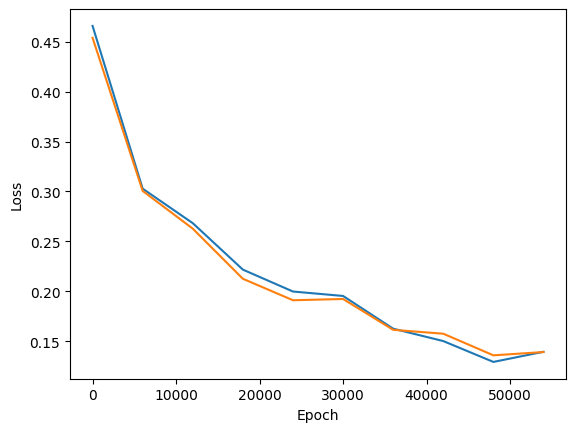

  0%|          | 0/10000 [00:00<?, ?it/s]

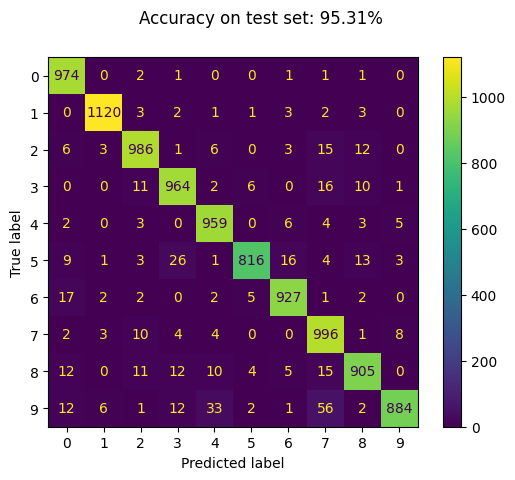

In [30]:
em = ExperimentManager("cnn_60000_it")
em.load_data(train_images, train_encoded_labels, test_images, test_encoded_labels)
em.experiment(nn, epochs = epochs, is_batch_mode = is_batch_mode, batch_size = batch_size, decay_step=decay_step)

In [86]:
occlusion_window_size = (3, 3)

In [107]:
def get_modified_images(images, labels, window_size, n = 3):
    images_dict = {}
    
    def get_n_label_images(search_label):
        nonlocal labels, n, images, images_dict
        result = []
        for i, label in enumerate(labels):
            if label == search_label:
                if len(result) == n:
                    break
                result.append(images[i])
        
        images_dict[search_label] = result
    
    for i in range(10):
        get_n_label_images(i)
    
    modified_images = {}
    for key, _images in images_dict.items():
        modified_images[key] = []
        for image in _images:
            image = image.reshape((28, 28))
            for i in range(28 - window_size[0] + 1):
                for j in range(28 - window_size[1] + 1):
                    copy_image = image.copy()
                    copy_image[i:(i + window_size[0]), j:(j + window_size[1])] = 0
                    modified_images[key].append(copy_image)
    
    return modified_images

In [108]:
images_dict = get_modified_images(train_images, train_labels, occlusion_window_size)

In [118]:
len(images_dict[0])

2028

In [126]:
prob_dict = {}
for i in range(10):
    prob_dict[i] = []

In [127]:
for key, _images in tqdm(images_dict.items()):
    for im in tqdm(_images):
        im = im.flatten()
        prob_dict[key].append(
            nn.forward(im)[0][key]
        )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

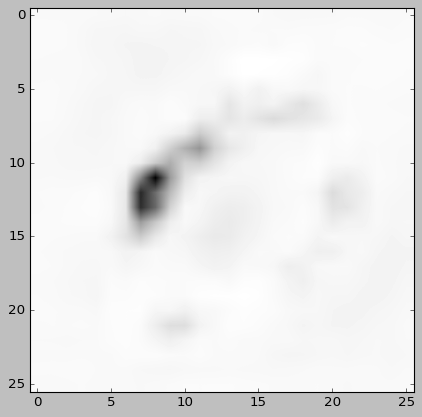

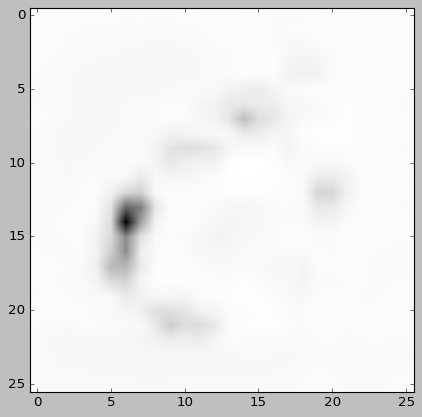

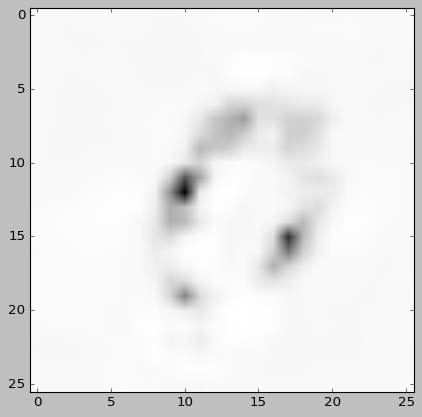

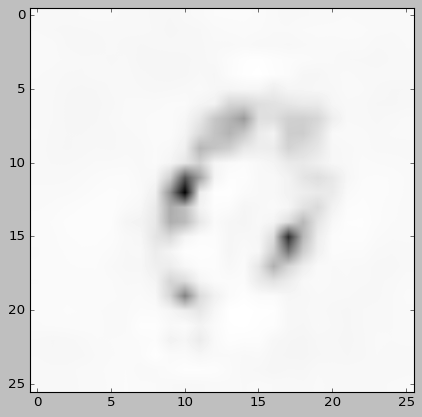

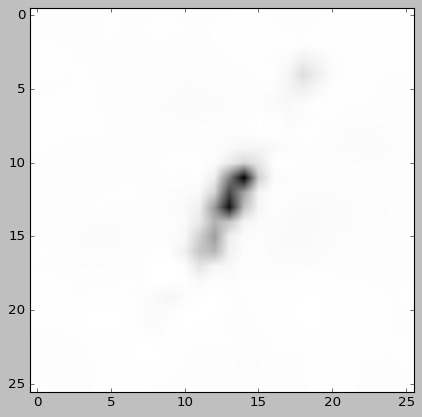

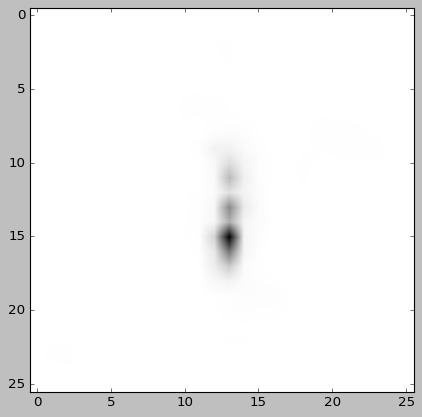

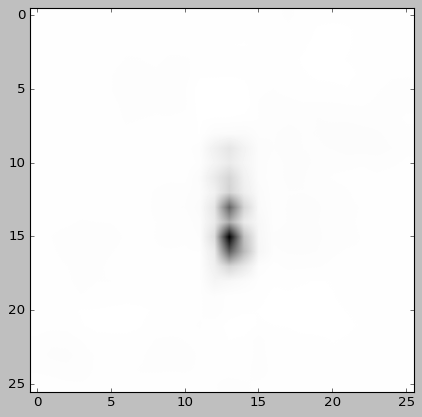

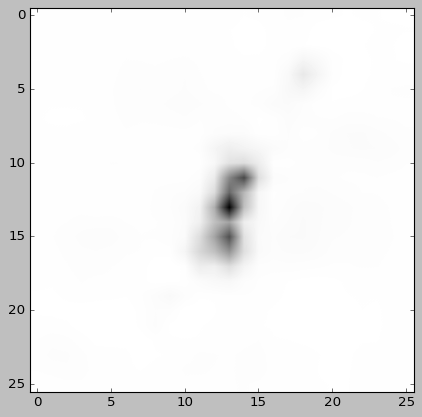

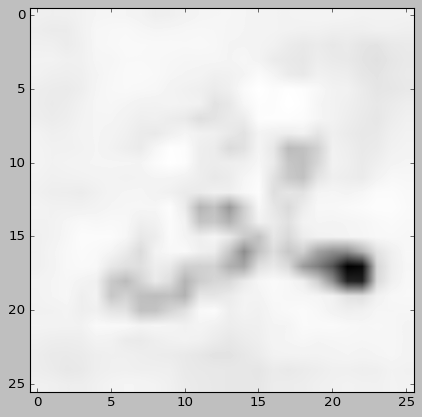

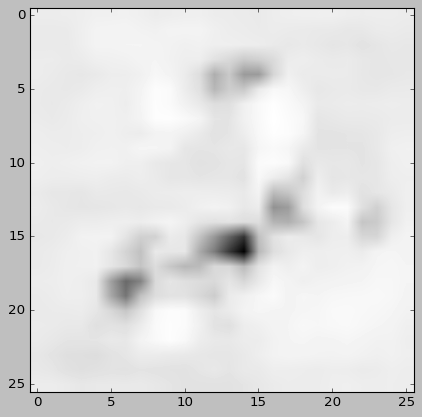

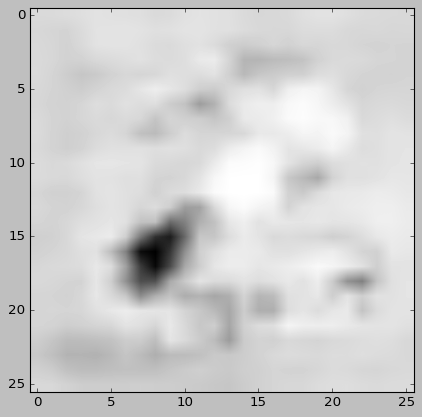

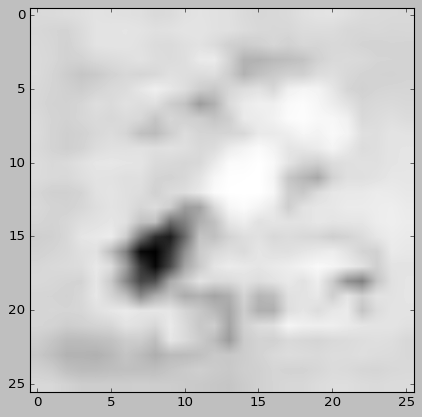

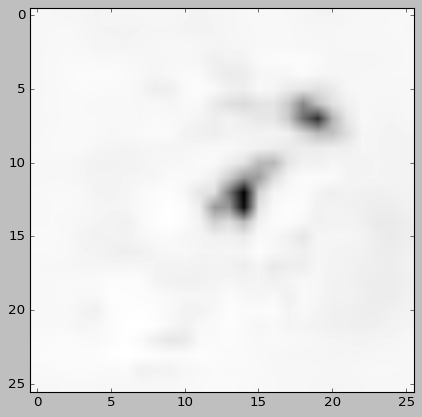

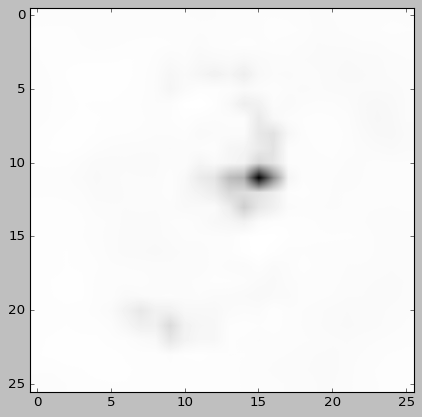

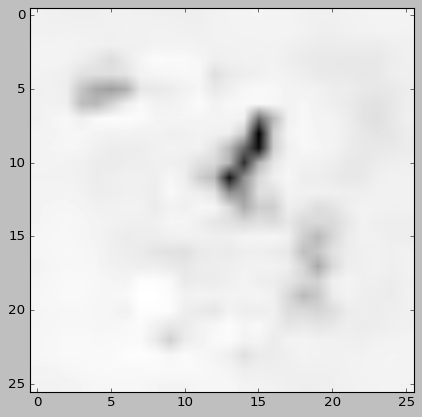

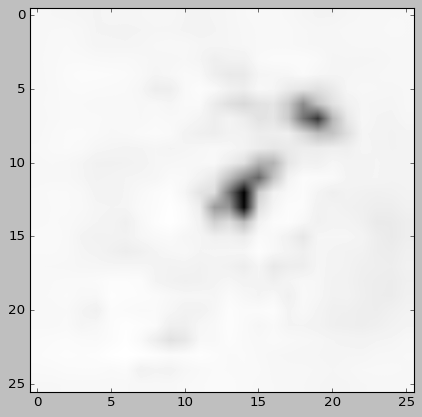

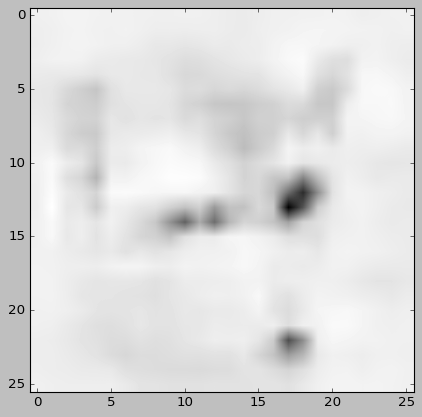

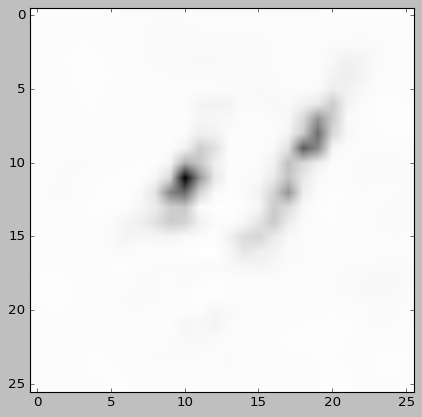

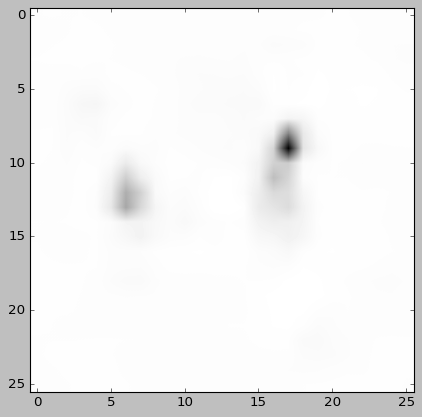

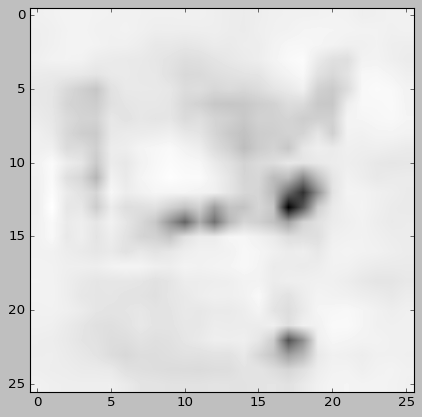

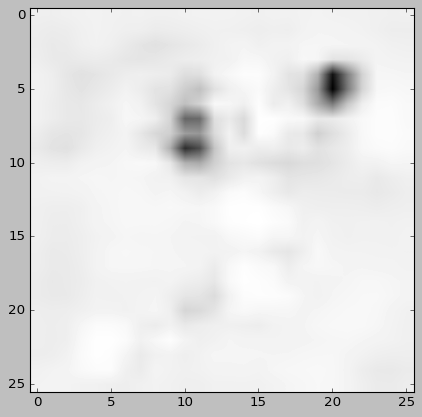

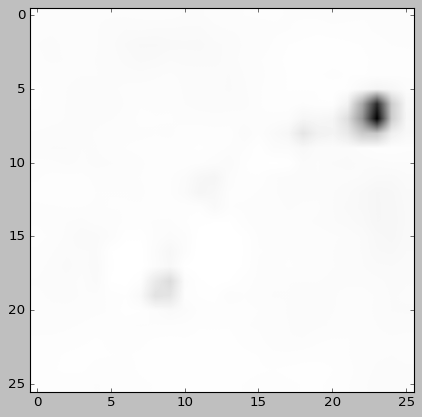

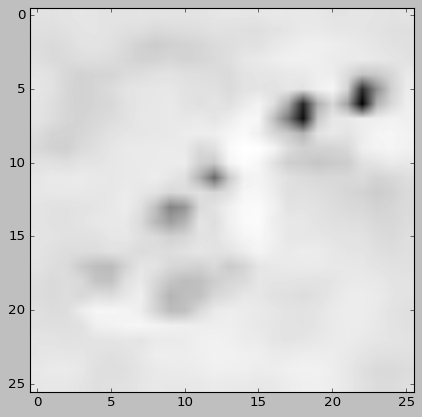

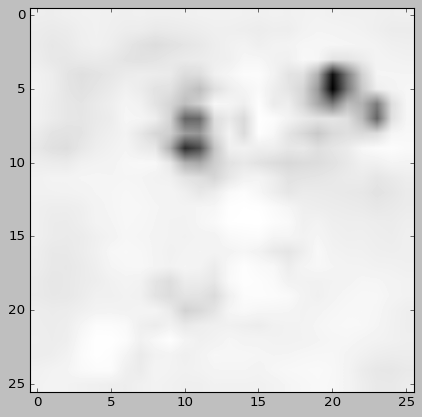

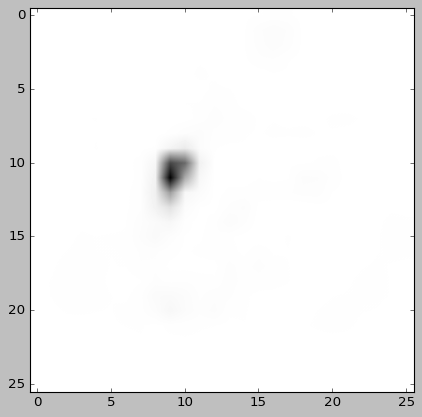

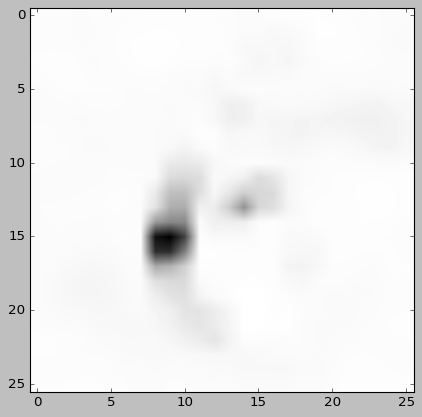

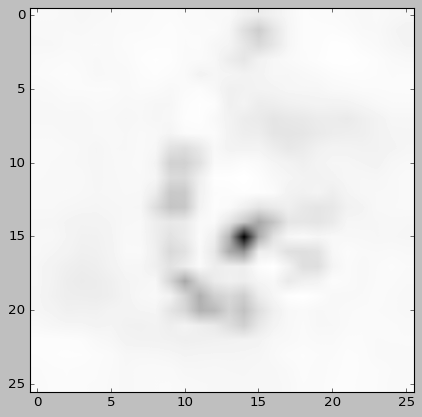

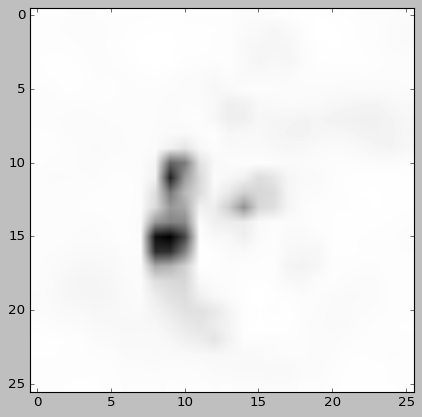

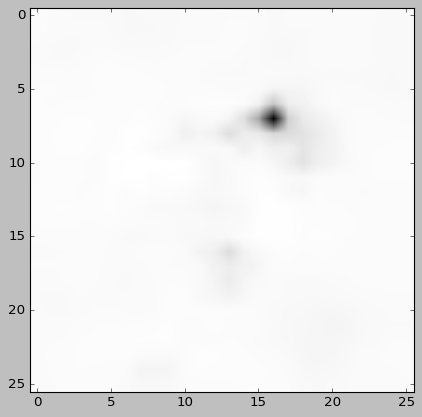

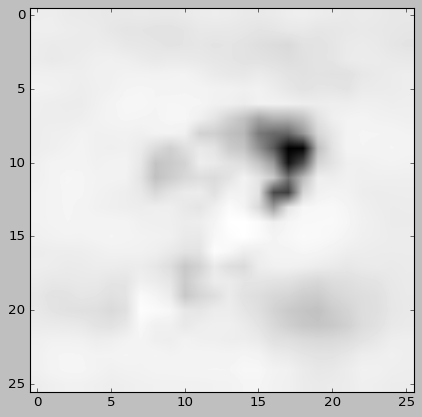

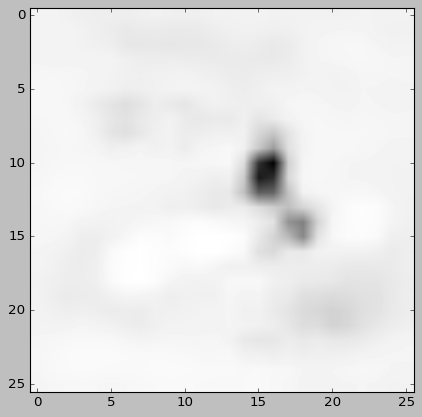

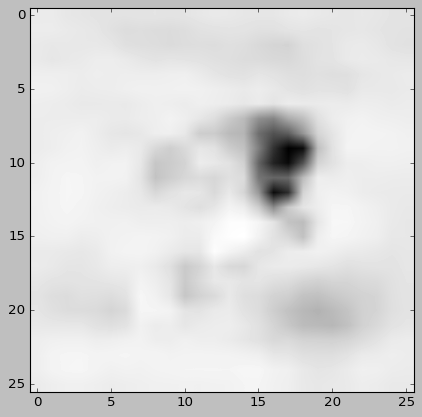

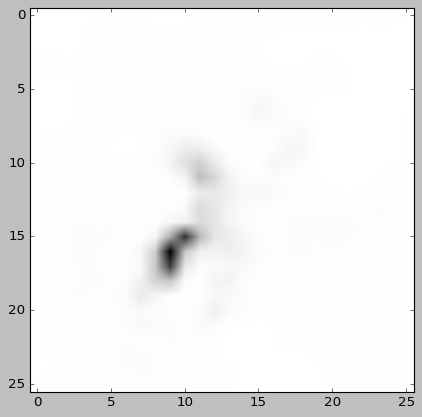

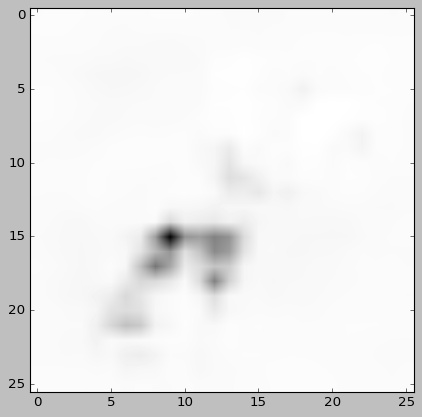

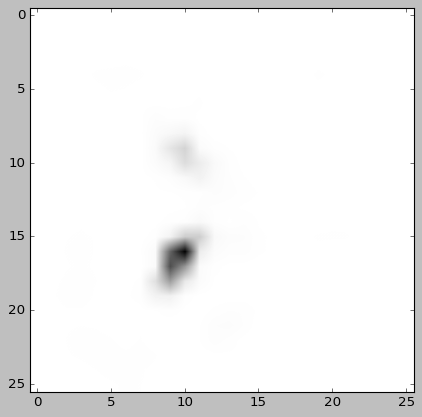

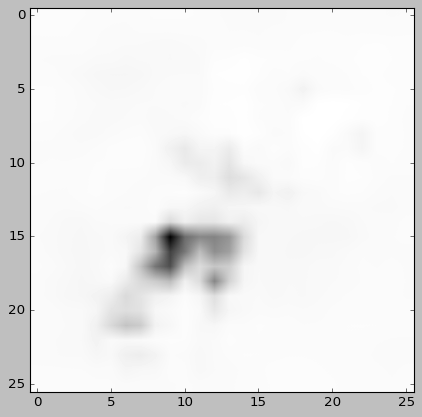

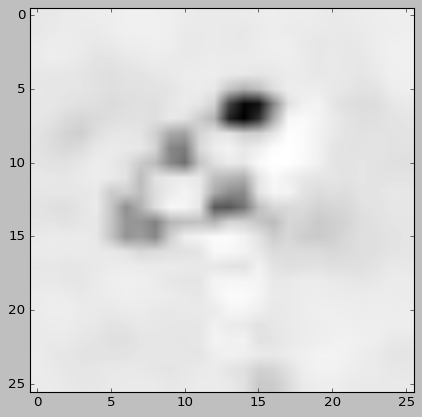

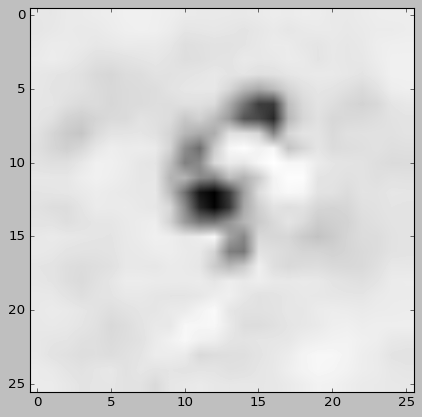

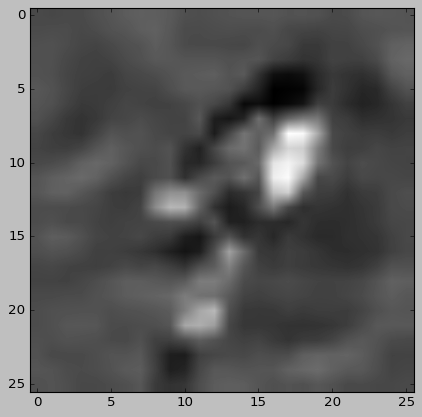

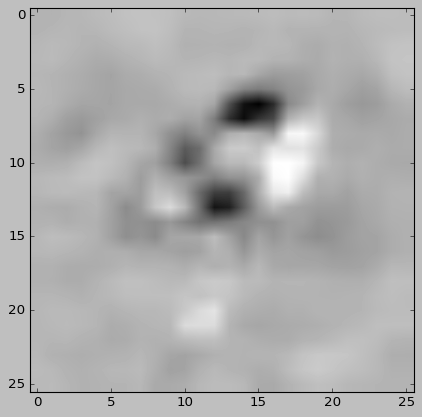

In [155]:
plt.style.use('classic')
for key, probs in prob_dict.items():
    probs = np.array(probs).reshape((3, 26, 26))
    for i in range(3):
        occlusion_im = probs[i,:,:]
        plt.imshow(occlusion_im, cmap=plt.get_cmap('gray'))
        plt.savefig(f"occlusions/{key}/{i}.png")
        plt.show()
    
    prob = np.average(probs, axis = 0)
    plt.imshow(prob, cmap=plt.get_cmap('gray'))
    plt.savefig(f"occlusions/avg_version/{key}.png")
    plt.show()